# COVID-19 Study with WHO Statistics

This is my first Jupyter notebook!

In [1]:
from datetime import timedelta, date, datetime
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import requests
import tabula

In [2]:
# set up display area to show dataframe in jupyter qtconsole

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
##################################################
# Country populations
##################################################

df_pop = pd.read_csv('Countries.csv', encoding='utf-8', index_col='Country')

In [4]:
##################################################
# Check whether the data already exists on disk
##################################################

if os.path.exists('COVID-19_WHO_Cases.csv'):
    print("Database exists - Reading it")

    df_cases = pd.read_csv('COVID-19_WHO_Cases.csv', encoding='utf-8', index_col='Country')
    df_deaths = pd.read_csv('COVID-19_WHO_Deaths.csv', encoding='utf-8', index_col='Country')

    first_dt = datetime.strptime('2020-02-03',"%Y-%m-%d")
    start_dt = datetime.strptime(df_cases.columns.values[-1],'%Y-%m-%d') + timedelta(1)
    start_rep = 14 + int ((start_dt - first_dt).days)
else:
    print("Database does not exist - Building it")

    ##################################################
    # Hard-code first data
    ##################################################
    
    df_cases = df_pop.copy()
    df_deaths = df_pop.copy()

    start_dt = datetime.strptime('2020-02-03',"%Y-%m-%d")
    start_rep = 14

Database exists - Reading it


In [5]:
##################################################
# Update data if needed
##################################################

end_dt = datetime.now() - timedelta(1)

for dt in range(int ((end_dt - start_dt).days)+1):
    new_date = start_dt + timedelta(dt)
    new_rep = start_rep + dt
    if new_rep >= 24:
        who_file = new_date.strftime("%Y%m%d")+"-sitrep-"+str(new_rep)+"-covid-19.pdf"
    else:
        who_file = new_date.strftime("%Y%m%d")+"-sitrep-"+str(new_rep)+"-ncov.pdf"
        
    new_date = new_date.strftime("%Y-%m-%d")
    print("Adding "+new_date+" to database")

    file = "WHO/"+who_file

    ##################################################
    # Download file from WHO if not on disk
    ##################################################

    if not os.path.exists(file):
        print("File missing - Downloading "+file)
        response = requests.get("https://www.who.int/docs/default-source/coronaviruse/situation-reports/"+who_file)
        if response.status_code >= 400:
            print("Does not exist")
            sys.exit()
        else:
            with open(file, 'wb') as f:
                f.write(response.content)

    ##################################################
    # Get World statistics
    ##################################################

    tab_who = tabula.read_pdf(file, pages="all", silent=True, pandas_options={'header': None})

    if len(tab_who) > 0:
        df_who = pd.concat(tab_who)
        cols = list(i for i in range(7,len(df_who.columns),1))
        df_who.drop(df_who.columns[cols], axis=1, inplace = True)
        df_who.replace(to_replace = '\s*\(.*\)', value = '', regex = True, inplace = True)
        df_who.replace(to_replace = '\s*\[.*\]', value = '', regex = True, inplace = True)

        if new_rep >= 42:
            # Format for reports 42+
            df_who.drop(df_who.columns[[2,4,5,6]], axis=1, inplace = True)
        elif new_rep >= 39:
            # Format for reports 39-41, fewer columns than the rest
            cols = list(i for i in range(3,len(df_who.columns),1))
            df_who.drop(df_who.columns[cols], axis=1, inplace = True)
        elif new_rep == 38:
            # Format for reports 38
            tab_who[2].drop(tab_who[2].columns[[2,3,4]], axis=1, inplace = True)
            tab_who[3].drop(tab_who[3].columns[[2,3,4,5]], axis=1, inplace = True)
            df_who = pd.concat(tab_who)
            df_who.replace(to_replace = '\s*\(.*\)', value = '', regex = True, inplace = True)
            df_who.replace(to_replace = '\s*\[.*\]', value = '', regex = True, inplace = True)
        elif new_rep == 31:
            # Special format for report 31, as Cases get merged into the country
            df_who = tab_who[1]
            df_who.replace(to_replace = '\s*\(.*\)', value = '', regex = True, inplace = True)
            df_who = df_who[df_who.columns[0]].str.rsplit(' ', 1, expand = True)
            df_who[2] = tab_who[1][4]
        elif new_rep >= 30:
            # Format for reports 30 and 32-37
            df_who.drop(df_who.columns[[2,3,4]], axis=1, inplace = True)
        elif new_rep >= 25:
            # Format for reports 25-29
            df_who.drop(df_who.columns[[1,3,4,5]], axis=1, inplace = True)
        elif new_rep >= 23:
            # Format for reports 23-24
            df_who.drop(df_who.columns[[0,3,4]], axis=1, inplace = True)
        elif new_rep == 17:
            # Format for reports 17
            df_who.drop(df_who.columns[[1,3,4,5]], axis=1, inplace = True)
        elif new_rep >= 14:
            # Format for reports 14-16 and 18-22
            df_who.drop(df_who.columns[[0,3]], axis=1, inplace = True)
        else:
            print("Not programmed to extract this report")
            sys.exit()

        df_who.replace(to_replace = '\s\d*$', value = '', regex = True, inplace = True)
        df_who = df_who[pd.to_numeric(df_who[df_who.columns[1]], errors='coerce').notnull()]
        df_who = df_who[pd.to_numeric(df_who[df_who.columns[2]], errors='coerce').notnull()]
        df_who.dropna(inplace = True)
        df_who.reset_index(drop = True, inplace = True)
        #df_who.drop(df_who.index[0], inplace = True)
            
        df_who.rename(columns = {df_who.columns[0]:'Country',df_who.columns[1]:'Cases',df_who.columns[2]:'Deaths'},
            inplace=True)
        df_who['Country'] = df_who['Country'].astype(str)
        df_who['Cases'] = df_who['Cases'].astype(int)
        df_who['Deaths'] = df_who['Deaths'].astype(int)
        
        df_who['Country'] = df_who['Country'].str.replace('’','\'')
        df_who['Country'] = df_who['Country'].str.replace('\r',' ')
        df_who['Country'] = df_who['Country'].str.replace('\W*$','')
        df_who['Country'] = df_who['Country'].str.replace('^the ','')
        df_who['Country'] = df_who['Country'].str.replace('^The ','')
        df_who['Country'] = df_who['Country'].str.replace('Syria.*','Syria')
        df_who['Country'] = df_who['Country'].str.replace('.*Tanzania','Tanzania')
        df_who['Country'] = df_who['Country'].str.replace('occupied Palestinian territory','Palestine')
        df_who['Country'] = df_who['Country'].str.replace('^Kingdom','United Kingdom')
        df_who['Country'] = df_who['Country'].str.replace('^Congo','Republic of the Congo')
        df_who['Country'] = df_who['Country'].str.replace('Viet Nam','Vietnam')
        df_who['Country'] = df_who['Country'].str.replace(' of America','')
        df_who['Country'] = df_who['Country'].str.replace('Holy See','Vatican City')
        df_who['Country'] = df_who['Country'].str.replace('conveyance','Diamond Princess')
        df_who.replace(to_replace = 'Serbia.*', value = 'Serbia', regex = True, inplace = True)

        df_who.set_index('Country', inplace = True)
        df_who.to_csv('WHO/'+new_date+'.csv', index = True, encoding='utf-8')

        df_cases[new_date] = df_who['Cases']
        df_deaths[new_date] = df_who['Deaths']

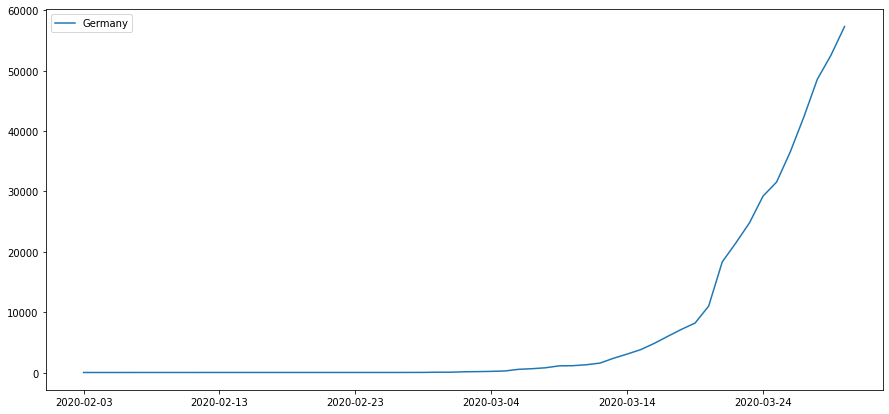

In [6]:
##################################################
# Save and plot data
##################################################

df_cases.to_csv('COVID-19_WHO_Cases.csv', index = True, encoding='utf-8')
df_deaths.to_csv('COVID-19_WHO_Deaths.csv', index = True, encoding='utf-8')

df_cases.fillna(0, inplace = True)
df_deaths.fillna(0, inplace = True)

df_germany = df_cases.drop(['Continental Region','Statistical Region','Population'], axis=1).loc['Germany']
df_germany.plot(figsize=(15,7),legend=True)
#df_cases.set_index('Date', inplace=True)
#df_cases.groupby('Country')['Cases'].plot(figsize=(15,7),legend=True)
plt.savefig("COVID-19_WHO.png")

Max = 122653.0
  0 - Indonesia                          : Pop =  270625568 - Cases =  1285 (0.00 per thousand)
  1 - Malaysia                           : Pop =   31949777 - Cases =  2470 (0.08 per thousand)
  2 - Chile                              : Pop =   18952038 - Cases =  1909 (0.10 per thousand)
  3 - Bolivia                            : Pop =   11513100 - Cases =    74 (0.01 per thousand)
  4 - Peru                               : Pop =   32510453 - Cases =   671 (0.02 per thousand)
  5 - Argentina                          : Pop =   44780677 - Cases =   745 (0.02 per thousand)
  6 - Dhekelia                           
  7 - Cyprus                             : Pop =    1179551 - Cases =   214 (0.18 per thousand)
  8 - India                              : Pop = 1366417754 - Cases =  1071 (0.00 per thousand)
  9 - China                              : Pop = 1433783686 - Cases = 82447 (0.06 per thousand)
 10 - Israel                             : Pop =    8519377 - Cases =  4247 (0.

<Figure size 432x288 with 0 Axes>

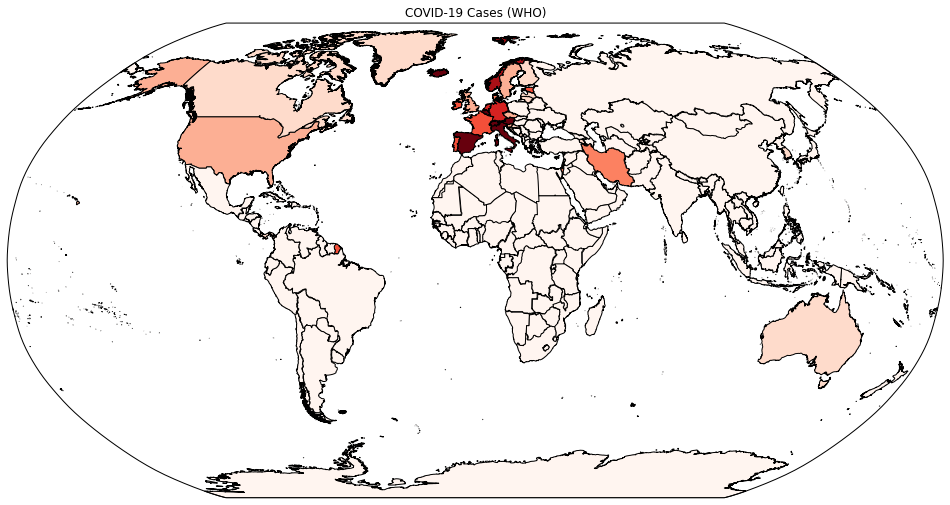

In [15]:
##################################################
# Plot world map
##################################################

end_dt = end_dt.strftime("%Y-%m-%d")

reds = cm.get_cmap('Reds', 8)

plt.clf()
fig = plt.figure(figsize=(13,8))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.Robinson())

shapename = 'admin_0_countries'
#shapename = 'admin_0_sovereignty'
shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name=shapename)
reader = shpreader.Reader(shapefile)
countries = list(reader.records())

# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
#ax.background_patch.set_visible(False)
#ax.outline_patch.set_visible(False)

cases_max = max(df_cases.loc[:,end_dt])
print("Max = "+str(cases_max))
colors = []
shapes = []
for n in range(len(countries)):
    country = countries[n].attributes['NAME_LONG']
    if country == 'eSwatini': country = 'Eswatini'
    elif country == 'The Gambia': country = 'Gambia'
    elif country == 'Lao PDR': country = 'Laos'
    elif country == 'Dem. Rep. Korea': country = 'North Korea'
    elif country == 'Moldova': country = 'Republic of Moldova'
    elif country == 'Macedonia': country = 'North Macedonia'
    elif country == 'Czech Republic': country = 'Czechia'
    if country in df_cases.index:
        cases = df_cases.loc[country,end_dt]
        pop = df_cases.loc[country,'Population']
        print("{0:3d} - {1:35s}: Pop = {2:10.0f} - Cases = {3:5.0f} ({4:.2f} per thousand)".format(
            n, country, pop, cases, 1000*cases/pop))
        colors.append(reds(1000*cases/pop))
    else:
        print("{0:3d} - {1:35s}".format(n, country))
        colors.append(reds(0))
    shapes.append(countries[n].geometry)
    ax.add_geometries([shapes[n]], ccrs.PlateCarree(), facecolor=colors[n], edgecolor='black')
    
ax.set_title('COVID-19 Cases (WHO)')

plt.savefig("MAP_WHO.png")

In [8]:
import geopandas as gpd

geofile = '/home/martel/.local/share/cartopy/shapefiles/natural_earth/cultural/ne_110m_admin_0_countries.shp'

df_geo = gpd.read_file(geofile)[['NAME_LONG', 'ADM0_A3', 'geometry']]
df_geo.columns = ['country','code','geometry']

In [13]:
merged = df_geo.merge(df_cases, left_on = 'country', right_on = 'Country', how = 'left')

In [10]:
import json

#Read data to json.
merged_json = json.loads(merged.to_json())

#Convert to String like object.
json_data = json.dumps(merged_json)

In [14]:
from bokeh.io import curdoc, output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, Slider, HoverTool
from bokeh.palettes import brewer
from bokeh.layouts import widgetbox, row, column


#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]

#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 100000)

#Define custom tick labels for color bar.
tick_labels = {'20000': '20k', '40000': '40k', '60000':'60k', '80000':'80k', '100000':'100k'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Add hover tool
hover = HoverTool(tooltips = [ ('Country/region','@country'),('% obesity', '@2020-03-30')])

#Create figure object.
p = figure(title = 'Current cases', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
start_dt = datetime.strptime('2020-02-03',"%Y-%m-%d")
start_rep = 14
show_rep = 70
show_date = (start_dt + timedelta(show_rep-start_rep)).strftime("%Y-%m-%d")

p.patches('xs','ys', source = geosource, fill_color = {'field' : show_date, 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

# Define the callback function: update_plot
def update_plot(attr, old, new):
    show_rep = slider.value
    show_date = (start_dt + timedelta(show_rep-start_rep)).strftime("%Y-%m-%d")
    
# Make a slider object: slider 
slider = Slider(title = 'Report', start = 14, end = 70, step = 1, value = 70)
slider.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
layout = column(p,widgetbox(slider))
curdoc().add_root(layout)

#Display plot inline in Jupyter notebook
output_notebook()

#Display plot
show(layout)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [ ]:
from bokeh.io import curdoc, output_notebook
from bokeh.models import Slider, HoverTool
from bokeh.layouts import widgetbox, row, column

#Define function that returns json_data for year selected by user.
    
def json_data(selectedYear):
    yr = selectedYear
    df_yr = df[df['year'] == yr]
    merged = gdf.merge(df_yr, left_on = 'country', right_on = '', how = 'left')
    merged.fillna('No data', inplace = True)
    merged_json = json.loads(merged.to_json())
    json_data = json.dumps(merged_json)
    return json_data

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data(2016))

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]

#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40, nan_color = '#d9d9d9')

#Define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', 
               '40': '>40%'}

#Add hover tool
hover = HoverTool(tooltips = [ ('Country/region','@country'),('% obesity', '@per_cent_obesity')])

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal', 
                     major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Share of adults who are obese, 2016', plot_height = 600 , plot_width = 950, 
           toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' :'per_cent_obesity', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify layout
p.add_layout(color_bar, 'below')

# Define the callback function: update_plot
def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    geosource.geojson = new_data
    p.title.text = 'Share of adults who are obese, %d' %yr
    
# Make a slider object: slider 
slider = Slider(title = 'Year',start = 1975, end = 2016, step = 1, value = 2016)
slider.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
layout = column(p,widgetbox(slider))
curdoc().add_root(layout)

#Display plot inline in Jupyter notebook
output_notebook()

#Display plot
show(layout)